<div class="alert alert-block alert-warning">
    <h1><center> Introduction to Deep Learning - Project  </center></h1>

# Importing required libraries

In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data Loading, Preparation, and Preprocessing

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()
CIFAR100_LABELS = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy',
    'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish',
    'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange',
    'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk',
    'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe',
    'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

# To map class names to indices
def map_classes_to_indices(selected_classes, class_labels):
    return [class_labels.index(cls) for cls in selected_classes]

# To extract data for selected classes
def extract_data_for_classes(x_data, y_data, selected_class_indices):
    selected_indices = np.isin(y_data, selected_class_indices).flatten()
    x_selected = x_data[selected_indices]
    y_selected = y_data[selected_indices]

    return x_selected, y_selected

# To map original labels to new class indices
def remap_labels(y_data, selected_class_indices):
    class_mapping = {old_label: new_label for new_label, old_label in enumerate(selected_class_indices)}
    return np.vectorize(class_mapping.get)(y_data)

# To reduce dataset size by selecting a fixed number of samples per class
def reduce_dataset_size(x_data, y_data, num_images_per_class):
    x_final, y_final = [], []
    for cls in range(len(selected_classes)):
        cls_indices = np.where(y_data == cls)[0][:num_images_per_class]
        x_final.append(x_data[cls_indices])
        y_final.append(y_data[cls_indices])
    x_final = np.concatenate(x_final, axis=0)
    y_final = np.concatenate(y_final, axis=0)

    return x_final, y_final

# To preprocess data
def preprocess_data(x_data, y_data, num_classes):
    x_data = x_data.astype('float32') / 255.0
    y_data = to_categorical(y_data, num_classes=num_classes)

    return x_data, y_data

# We can either select classes like this or randomly choose
# selected_classes = ['skyscraper', 'motorcycle', 'poppy', 'squirrel', 'dinosaur', 'worm', 'plain', 'tractor', 'keyboard', 'rocket']

# 10 random classes from CIFAR-100
np.random.seed(62)  # To ensure reproducibility
selected_classes = np.random.choice(CIFAR100_LABELS, 10, replace=False)
print(f"Selected classes: {selected_classes}")

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
Selected classes: ['skyscraper' 'motorcycle' 'poppy' 'squirrel' 'dinosaur' 'worm' 'plain'
 'tractor' 'keyboard' 'rocket']


In [ ]:
selected_class_indices = map_classes_to_indices(selected_classes, CIFAR100_LABELS)

x_train_selected, y_train_selected = extract_data_for_classes(x_train, y_train, selected_class_indices)
x_test_selected, y_test_selected = extract_data_for_classes(x_test, y_test, selected_class_indices)

y_train_selected = remap_labels(y_train_selected, selected_class_indices)
y_test_selected = remap_labels(y_test_selected, selected_class_indices)

x_train_final, y_train_final = reduce_dataset_size(x_train_selected, y_train_selected, 300)
x_test_final, y_test_final = reduce_dataset_size(x_test_selected, y_test_selected, 50)

x_train_final, y_train_final = preprocess_data(x_train_final, y_train_final, len(selected_classes))
x_test_final, y_test_final = preprocess_data(x_test_final, y_test_final, len(selected_classes))

print(f"Train Data Shape: {x_train_final.shape}, Train Labels: {y_train_final.shape}")
print(f"Test Data Shape: {x_test_final.shape}, Test Labels: {y_test_final.shape}")

Train Data Shape: (3000, 32, 32, 3), Train Labels: (3000, 10)
Test Data Shape: (500, 32, 32, 3), Test Labels: (500, 10)


# Building and Evaluating Base CNN Model

In [ ]:
def build_cnn_model(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))

    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

cnn_model = build_cnn_model()
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,341,226 (5.12 MB)

 Trainable params: 1,341,226 (5.12 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = cnn_model.fit(x_train_final, y_train_final,
                    epochs=25,
                    batch_size=64,
                    validation_data=(x_test_final, y_test_final))

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 172ms/step - accuracy: 0.1351 - loss: 2.2576 - val_accuracy: 0.2880 - val_loss: 1.9058
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.3222 - loss: 1.8622 - val_accuracy: 0.3900 - val_loss: 1.6800
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3999 - loss: 1.6578 - val_accuracy: 0.4080 - val_loss: 1.6073
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4424 - loss: 1.5254 - val_accuracy: 0.4680 - val_loss: 1.4579
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4799 - loss: 1.4222 - val_accuracy: 0.5400 - val_loss: 1.2601
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5370 - loss: 1.2735 - val_accuracy: 0.5480 - val_loss: 1.1815
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5952 - loss: 1.1417 - val_accuracy: 0.6060 - val_loss: 1.1116
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6256 - loss: 1.0611 - val_accuracy: 0.5980 - val_l

In [ ]:
test_loss, test_accuracy = cnn_model.evaluate(x_test_final, y_test_final)
print(f"Accuracy: {test_accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7770 - loss: 0.7539
Accuracy: 75.80%


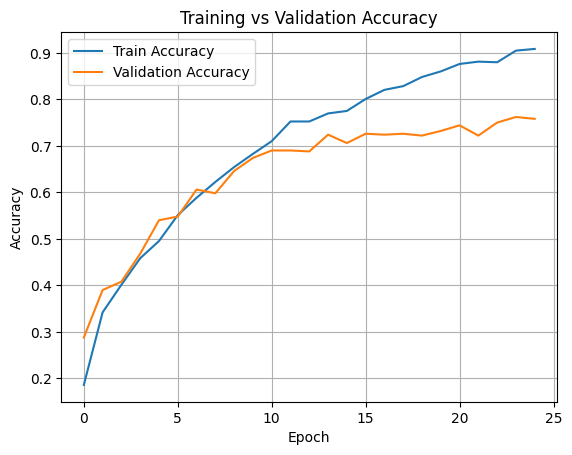

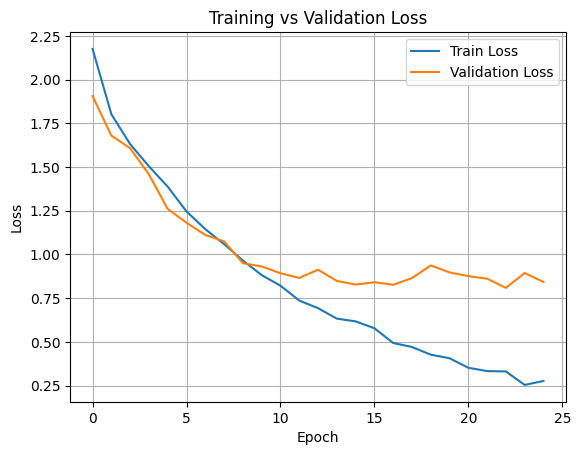

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

print("")
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Experiments to Improve Accuracy (part 5)

## 1. Increasing the size and depth of the inner layers

In [ ]:
def build_deeper_model(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))

    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
deeper_model = build_deeper_model()
deeper_history = deeper_model.fit(x_train_final, y_train_final, epochs=25, batch_size=64, validation_data=(x_test_final, y_test_final))

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 38s 407ms/step - accuracy: 0.1736 - loss: 3.9699 - val_accuracy: 0.1420 - val_loss: 4.1215
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.3610 - loss: 3.0319 - val_accuracy: 0.1000 - val_loss: 6.3520
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.4565 - loss: 2.6619 - val_accuracy: 0.1000 - val_loss: 7.7207
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4990 - loss: 2.5031 - val_accuracy: 0.1620 - val_loss: 5.6463
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5485 - loss: 2.3551 - val_accuracy: 0.2200 - val_loss: 5.2236
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5995 - loss: 2.1978 - val_accuracy: 0.1600 - val_loss: 5.2319
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5967 - loss: 2.1537 - val_accuracy: 0.2300 - val_loss: 3.9148
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6144 - loss: 2.0106 - val_accuracy: 0.2520 -

In [ ]:
deeper_test_loss, deeper_test_accuracy = deeper_model.evaluate(x_test_final, y_test_final)
print(f"Accuracy after optimizations: {deeper_test_accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.7496 - loss: 1.3025
Accuracy after optimizations: 68.80%


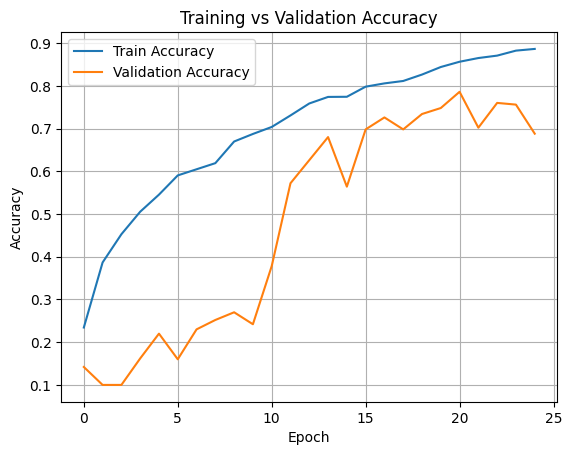

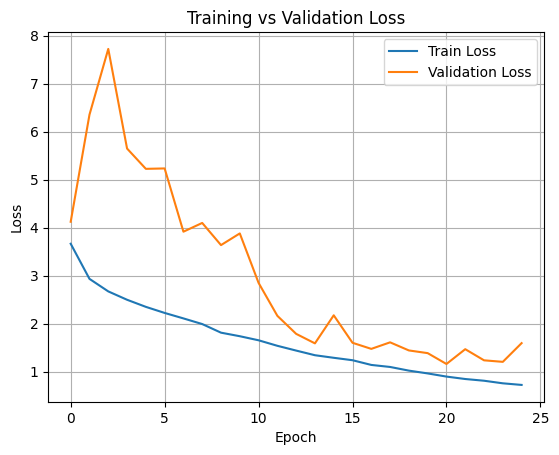

In [ ]:
plt.plot(deeper_history.history['accuracy'], label='Train Accuracy')
plt.plot(deeper_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

print("")
plt.plot(deeper_history.history['loss'], label='Train Loss')
plt.plot(deeper_history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Trying fine tuning on deeper model with data augmentation to check results

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    zoom_range=0.05
)
datagen.fit(x_train_final)

In [ ]:
# Training without augmentation
baseline_model = build_deeper_model()
baseline_model.fit(
    x_train_final, y_train_final,
    epochs=20,
    validation_data=(x_test_final, y_test_final)
)

# Fine tuning with augmentation
aug_history = baseline_model.fit(
    datagen.flow(x_train_final, y_train_final, batch_size=64),
    epochs=50,
    validation_data=(x_test_final, y_test_final)
)

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 30s 149ms/step - accuracy: 0.1952 - loss: 3.8852 - val_accuracy: 0.1000 - val_loss: 4.9103
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.3771 - loss: 2.9679 - val_accuracy: 0.1660 - val_loss: 4.7223
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4692 - loss: 2.6448 - val_accuracy: 0.2600 - val_loss: 3.6066
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4957 - loss: 2.4983 - val_accuracy: 0.2120 - val_loss: 3.4920
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5618 - loss: 2.2538 - val_accuracy: 0.4100 - val_loss: 2.6451
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6038 - loss: 2.0905 - val_accuracy: 0.6140 - val_loss: 1.9911
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6479 - loss: 1.9044 - val_accuracy: 0.5440 - val_loss: 2.0283
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6662 - loss: 1.7706 - val_accuracy: 0.5100 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 220ms/step - accuracy: 0.8204 - loss: 0.9264 - val_accuracy: 0.7640 - val_loss: 1.1097
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8615 - loss: 0.7982 - val_accuracy: 0.7820 - val_loss: 0.9899
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8641 - loss: 0.7495 - val_accuracy: 0.8080 - val_loss: 0.8847
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8577 - loss: 0.7549 - val_accuracy: 0.7520 - val_loss: 1.1414
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8634 - loss: 0.7153 - val_accuracy: 0.7940 - val_loss: 0.9109
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8729 - loss: 0.6525 - val_accuracy: 0.8300 - val_loss: 0.7977
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.8737 - loss: 0.6432 - val_accuracy: 0.7760 - val_loss: 0.9864
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8815 - loss: 0.6177 - val_accuracy: 0.7360 - val_loss: 

In [ ]:
aug_test_loss, aug_test_accuracy = baseline_model.evaluate(x_test_final, y_test_final)
print(f"Accuracy after fine tuning: {aug_test_accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7509 - loss: 1.2022
Accuracy after fine tuning: 71.60%


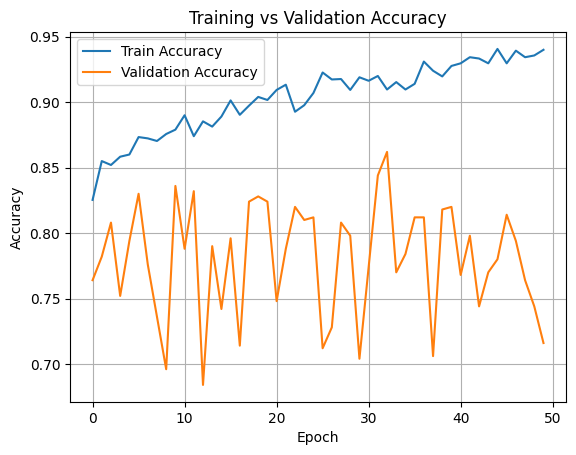

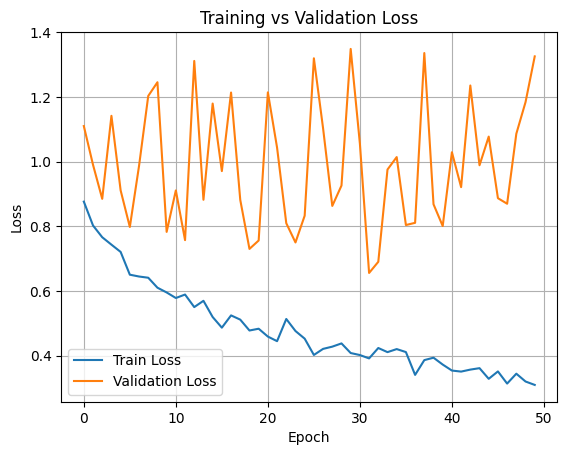

In [ ]:
plt.plot(aug_history.history['accuracy'], label='Train Accuracy')
plt.plot(aug_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

print("")
plt.plot(aug_history.history['loss'], label='Train Loss')
plt.plot(aug_history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## 2. Using fewer or more convolutional/maxpooling layers and different shapes

In [ ]:
def build_simpler_model(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))

    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
simpler_model = build_simpler_model()
history_simple = simpler_model.fit(x_train_final, y_train_final,
                                  epochs=25,
                                  batch_size=64,
                                  validation_data=(x_test_final, y_test_final))

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.2190 - loss: 2.1422 - val_accuracy: 0.4460 - val_loss: 1.6143
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4380 - loss: 1.5859 - val_accuracy: 0.5140 - val_loss: 1.3821
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5338 - loss: 1.3268 - val_accuracy: 0.5860 - val_loss: 1.2440
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5805 - loss: 1.2263 - val_accuracy: 0.6180 - val_loss: 1.1389
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6064 - loss: 1.0993 - val_accuracy: 0.6480 - val_loss: 1.0538
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6482 - loss: 1.0465 - val_accuracy: 0.6600 - val_loss: 1.0447
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6843 - loss: 0.9400 - val_accuracy: 0.6780 - val_loss: 0.9564
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7096 - loss: 0.8364 - val_accuracy: 0.6860 - val_loss

In [ ]:
simpler_test_loss, simpler_test_accuracy = simpler_model.evaluate(x_test_final, y_test_final)
print(f"Accuracy (simpler): {simpler_test_accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7506 - loss: 0.8359
Accuracy (simpler): 71.80%


In [ ]:
def build_deep_model(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))

    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
deep_model = build_deep_model()
history_deep = deep_model.fit(x_train_final, y_train_final,
                                  epochs=25,
                                  batch_size=64,
                                  validation_data=(x_test_final, y_test_final))

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.1495 - loss: 2.2294 - val_accuracy: 0.3300 - val_loss: 1.8141
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3266 - loss: 1.7765 - val_accuracy: 0.3760 - val_loss: 1.6142
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4135 - loss: 1.5823 - val_accuracy: 0.4620 - val_loss: 1.5082
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4732 - loss: 1.4739 - val_accuracy: 0.4940 - val_loss: 1.4614
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5241 - loss: 1.3181 - val_accuracy: 0.5600 - val_loss: 1.2485
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6023 - loss: 1.1370 - val_accuracy: 0.5660 - val_loss: 1.2466
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6270 - loss: 1.0862 - val_accuracy: 0.6260 - val_loss: 1.0473
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6664 - loss: 0.9903 - val_accuracy: 0.6520 -

In [ ]:
deep_test_loss, deep_test_accuracy = deep_model.evaluate(x_test_final, y_test_final)
print(f"Accuracy (deep): {deep_test_accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.7660 - loss: 1.1968
Accuracy (deep): 73.40%


## 3. Using different activation functions in the inner layers and in the convolutional layers

In [ ]:
def cnn_with_tanh(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='tanh'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='tanh'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='tanh'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='tanh'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
tanh_model = cnn_with_tanh()
tanh_history = tanh_model.fit(x_train_final, y_train_final,
                                  epochs=25,
                                  batch_size=64,
                                  validation_data=(x_test_final, y_test_final))

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.2905 - loss: 1.9817 - val_accuracy: 0.5640 - val_loss: 1.3473
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5476 - loss: 1.2829 - val_accuracy: 0.6180 - val_loss: 1.1175
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6401 - loss: 1.0561 - val_accuracy: 0.6240 - val_loss: 1.0213
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6855 - loss: 0.9105 - val_accuracy: 0.6700 - val_loss: 0.9538
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7205 - loss: 0.7947 - val_accuracy: 0.7300 - val_loss: 0.8609
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7730 - loss: 0.6624 - val_accuracy: 0.7120 - val_loss: 0.8563
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8148 - loss: 0.5402 - val_accuracy: 0.7160 - val_loss: 0.8088
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8359 - loss: 0.4650 - val_accuracy: 0.7300 - val_loss

In [ ]:
tanh_test_loss, tanh_test_accuracy = tanh_model.evaluate(x_test_final, y_test_final)
print(f"Accuracy (tanh): {tanh_test_accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7979 - loss: 0.8294
Accuracy (tanh): 76.80%


In [ ]:
def cnn_with_sigmoid(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='sigmoid'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='sigmoid'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='sigmoid'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='sigmoid'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
sigmoid_model = cnn_with_sigmoid()
sigmoid_history = sigmoid_model.fit(x_train_final, y_train_final,
                                  epochs=25,
                                  batch_size=64,
                                  validation_data=(x_test_final, y_test_final))

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.0973 - loss: 2.4631 - val_accuracy: 0.1000 - val_loss: 2.3111
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0996 - loss: 2.3163 - val_accuracy: 0.1000 - val_loss: 2.3146
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0957 - loss: 2.3128 - val_accuracy: 0.1040 - val_loss: 2.3024
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1110 - loss: 2.3070 - val_accuracy: 0.1280 - val_loss: 2.2947
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1280 - loss: 2.2842 - val_accuracy: 0.2060 - val_loss: 2.2282
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2424 - loss: 2.1191 - val_accuracy: 0.3080 - val_loss: 1.9169
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3409 - loss: 1.8277 - val_accuracy: 0.3360 - val_loss: 1.8262
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3773 - loss: 1.6972 - val_accuracy: 0.3540 - val_loss

In [ ]:
sigmoid_test_loss, sigmoid_test_accuracy = sigmoid_model.evaluate(x_test_final, y_test_final)
print(f"Accuracy (sigmoid): {sigmoid_test_accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5044 - loss: 1.3363
Accuracy (sigmoid): 48.80%


In [ ]:
def cnn_with_leaky_relu(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.Conv2D(32, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(256))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
leaky_relu_model = cnn_with_leaky_relu()
leaky_relu_history = leaky_relu_model.fit(x_train_final, y_train_final,
                                  epochs=25,
                                  batch_size=64,
                                  validation_data=(x_test_final, y_test_final))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.1613 - loss: 2.2271 - val_accuracy: 0.3240 - val_loss: 1.9207
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3214 - loss: 1.7821 - val_accuracy: 0.4680 - val_loss: 1.5437
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4361 - loss: 1.5472 - val_accuracy: 0.5160 - val_loss: 1.3109
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5083 - loss: 1.3695 - val_accuracy: 0.5460 - val_loss: 1.2436
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5736 - loss: 1.1745 - val_accuracy: 0.5780 - val_loss: 1.1819
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6494 - loss: 0.9657 - val_accuracy: 0.6600 - val_loss: 0.9535
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7038 - loss: 0.8971 - val_accuracy: 0.6700 - val_loss: 0.9966
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7351 - loss: 0.7448 - val_accuracy: 0.6720 - val

In [ ]:
leaky_relu_test_loss, leaky_relu_test_accuracy = leaky_relu_model.evaluate(x_test_final, y_test_final)
print(f"Accuracy (leaky_relu): {leaky_relu_test_accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7798 - loss: 0.9384
Accuracy (leaky_relu): 75.20%


In [ ]:
def cnn_with_swish(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), padding='same'))
    model.add(layers.Activation(tf.keras.activations.swish))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.Activation(tf.keras.activations.swish))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.Activation(tf.keras.activations.swish))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(256))
    model.add(layers.Activation(tf.keras.activations.swish))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
swish_model = cnn_with_swish()
swish_history = swish_model.fit(x_train_final, y_train_final,
                                  epochs=25,
                                  batch_size=64,
                                  validation_data=(x_test_final, y_test_final))

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.2420 - loss: 2.0963 - val_accuracy: 0.4860 - val_loss: 1.5004
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5204 - loss: 1.3962 - val_accuracy: 0.5940 - val_loss: 1.2078
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6062 - loss: 1.1529 - val_accuracy: 0.6060 - val_loss: 1.1472
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6300 - loss: 1.0407 - val_accuracy: 0.6160 - val_loss: 1.0612
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6814 - loss: 0.9233 - val_accuracy: 0.6600 - val_loss: 0.9808
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6950 - loss: 0.8730 - val_accuracy: 0.6780 - val_loss: 0.9532
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7229 - loss: 0.7712 - val_accuracy: 0.7060 - val_loss: 0.8486
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7773 - loss: 0.6544 - val_accuracy: 0.6840 - val_loss

In [ ]:
swish_test_loss, swish_test_accuracy = swish_model.evaluate(x_test_final, y_test_final)
print(f"Accuracy (swish): {swish_test_accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7824 - loss: 1.3668
Accuracy (swish): 74.60%


In [ ]:
def cnn_with_relu(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
relu_model = cnn_with_relu()
relu_history = relu_model.fit(x_train_final, y_train_final,
                                  epochs=25,
                                  batch_size=64,
                                  validation_data=(x_test_final, y_test_final))

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.2470 - loss: 2.0809 - val_accuracy: 0.4700 - val_loss: 1.5111
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4918 - loss: 1.4441 - val_accuracy: 0.5280 - val_loss: 1.3296
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5480 - loss: 1.2485 - val_accuracy: 0.6040 - val_loss: 1.1614
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6335 - loss: 1.0610 - val_accuracy: 0.6500 - val_loss: 1.0165
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6816 - loss: 0.9181 - val_accuracy: 0.6920 - val_loss: 0.9312
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7332 - loss: 0.7874 - val_accuracy: 0.7100 - val_loss: 0.9002
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7419 - loss: 0.7496 - val_accuracy: 0.6560 - val_loss: 0.9695
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7609 - loss: 0.6666 - val_accuracy: 0.7080 - val_loss

In [ ]:
relu_test_loss, relu_test_accuracy = relu_model.evaluate(x_test_final, y_test_final)
print(f"Accuracy (relu): {relu_test_accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7832 - loss: 0.9312
Accuracy (relu): 76.40%


In [ ]:
def cnn_with_swish_and_relu(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), padding='same'))
    model.add(layers.Conv2D(32, (3, 3), padding='same'))
    model.add(layers.Activation(tf.keras.activations.swish))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.Activation(tf.keras.activations.swish))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.Activation(tf.keras.activations.swish))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
swish_and_relu_model = cnn_with_swish_and_relu()
swish_and_relu_history = swish_and_relu_model.fit(x_train_final, y_train_final,
                                  epochs=25,
                                  batch_size=64,
                                  validation_data=(x_test_final, y_test_final))

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 0.1782 - loss: 2.1834 - val_accuracy: 0.3940 - val_loss: 1.7342
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.3696 - loss: 1.6923 - val_accuracy: 0.4260 - val_loss: 1.4921
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4832 - loss: 1.4635 - val_accuracy: 0.5580 - val_loss: 1.2839
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5426 - loss: 1.3194 - val_accuracy: 0.5900 - val_loss: 1.1760
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6012 - loss: 1.1417 - val_accuracy: 0.6140 - val_loss: 1.0681
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6531 - loss: 1.0052 - val_accuracy: 0.6740 - val_loss: 0.9228
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6848 - loss: 0.9263 - val_accuracy: 0.6680 - val_loss: 0.9168
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7482 - loss: 0.7416 - val_accuracy: 0.7020 - 

In [ ]:
swish_and_relu_test_loss, swish_and_relu_test_accuracy = swish_and_relu_model.evaluate(x_test_final, y_test_final)
print(f"Accuracy (swish_and_relu): {swish_and_relu_test_accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7527 - loss: 0.8538
Accuracy (swish_and_relu): 74.20%


In [ ]:
def cnn_with_swish_and_leaky_relu(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), padding='same'))
    model.add(layers.Conv2D(32, (3, 3), padding='same'))
    model.add(layers.Activation(tf.keras.activations.swish))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.Activation(tf.keras.activations.swish))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.Activation(tf.keras.activations.swish))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(256))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
swish_and_leaky_relu_model = cnn_with_swish_and_leaky_relu()
swish_and_leaky_relu_history = swish_and_leaky_relu_model.fit(x_train_final, y_train_final,
                                  epochs=25,
                                  batch_size=64,
                                  validation_data=(x_test_final, y_test_final))

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy: 0.2151 - loss: 2.1027 - val_accuracy: 0.4280 - val_loss: 1.5986
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4576 - loss: 1.5540 - val_accuracy: 0.5540 - val_loss: 1.3298
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5605 - loss: 1.2780 - val_accuracy: 0.5500 - val_loss: 1.2968
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6061 - loss: 1.1376 - val_accuracy: 0.6460 - val_loss: 1.0405
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6913 - loss: 0.9509 - val_accuracy: 0.6740 - val_loss: 0.9235
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7281 - loss: 0.8049 - val_accuracy: 0.7000 - val_loss: 0.9290
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7330 - loss: 0.7478 - val_accuracy: 0.6820 - val_loss: 0.8693
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7955 - loss: 0.6226 - val_accuracy: 0.6940 - val_l

In [ ]:
swish_and_leaky_relu_test_loss, swish_and_leaky_relu_test_accuracy = swish_and_leaky_relu_model.evaluate(x_test_final, y_test_final)
print(f"Accuracy (swish_and_leaky_relu): {swish_and_leaky_relu_test_accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7807 - loss: 0.9429
Accuracy (swish_and_leaky_relu): 74.60%


## 4. Using various optimizers and learning rate

In [ ]:
def build_model():
    model = models.Sequential()
    model.add(layers.Input(shape=(32, 32, 3)))
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(10, activation='softmax'))
    return model

optimizers = {
    'Adam': Adam,
    'SGD': SGD,
    'RMSprop': RMSprop,
    'Adagrad': Adagrad
}
learning_rates = [0.01, 0.001, 0.0001]

In [ ]:
results = []
for opt_name, opt_class in optimizers.items():
    for lr in learning_rates:
        print(f"\nTesting {opt_name} with learning rate {lr}")
        model = build_model()
        optimizer = opt_class(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(
            x_train_final, y_train_final,
            epochs=25,
            batch_size=64,
            validation_data=(x_test_final, y_test_final)
        )

        test_loss, test_acc = model.evaluate(x_test_final, y_test_final, verbose=0)
        print(f"Accuracy: {test_acc * 100:.2f}%")
        results.append((opt_name, lr, test_acc * 100))


Testing Adam with learning rate 0.01
Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 0.1058 - loss: 7.3038 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0955 - loss: 2.3035 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0850 - loss: 2.3033 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0991 - loss: 2.3031 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0924 - loss: 2.3031 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0862 - loss: 2.3031 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0939 - loss: 2.3033 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0885 - loss:

In [ ]:
print("Summary of results:")
for opt_name, lr, acc in results:
    print(f"{opt_name} (lr={lr}) → Accuracy: {acc:.2f}%")

Summary of results:
Adam (lr=0.01) → Accuracy: 10.00%
Adam (lr=0.001) → Accuracy: 77.80%
Adam (lr=0.0001) → Accuracy: 66.60%
SGD (lr=0.01) → Accuracy: 45.20%
SGD (lr=0.001) → Accuracy: 18.40%
SGD (lr=0.0001) → Accuracy: 9.40%
RMSprop (lr=0.01) → Accuracy: 10.00%
RMSprop (lr=0.001) → Accuracy: 75.20%
RMSprop (lr=0.0001) → Accuracy: 60.60%
Adagrad (lr=0.01) → Accuracy: 54.60%
Adagrad (lr=0.001) → Accuracy: 29.40%
Adagrad (lr=0.0001) → Accuracy: 10.60%


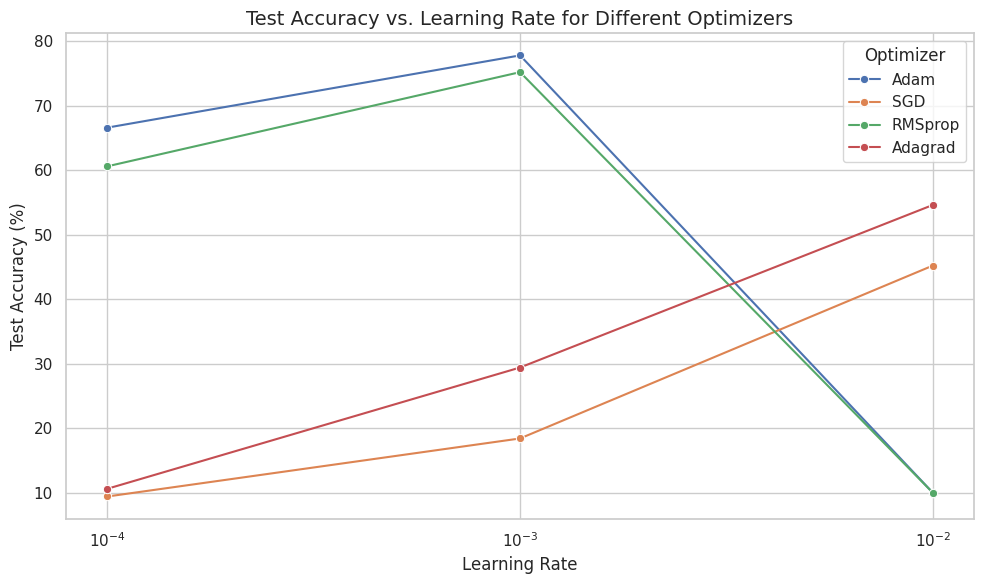

In [ ]:
df = pd.DataFrame(results, columns=["Optimizer", "Learning Rate", "Accuracy"])
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Learning Rate", y="Accuracy", hue="Optimizer", marker="o")
plt.title("Test Accuracy vs. Learning Rate for Different Optimizers", fontsize=14)
plt.xlabel("Learning Rate")
plt.ylabel("Test Accuracy (%)")
plt.legend(title="Optimizer")
plt.xscale("log")
plt.tight_layout()
plt.show()

## 5. Using various batch sizes and epochs for training

In [ ]:
batch_sizes = [32, 64, 128]
epochs_list = [10, 20, 30]
output = []

for batch_size in batch_sizes:
    for num_epochs in epochs_list:
        print(f"\nTraining with batch size {batch_size} and epochs {num_epochs}")

        model = build_model()
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(
            x_train_final, y_train_final,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_test_final, y_test_final)
        )

        test_loss, test_acc = model.evaluate(x_test_final, y_test_final, verbose=0)
        print(f"Accuracy: {test_acc * 100:.2f}%")
        output.append((batch_size, num_epochs, test_acc * 100))


Training with batch size 32 and epochs 10
Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.1849 - loss: 2.1859 - val_accuracy: 0.3200 - val_loss: 1.8360
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3563 - loss: 1.7745 - val_accuracy: 0.4120 - val_loss: 1.6162
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4315 - loss: 1.5815 - val_accuracy: 0.5020 - val_loss: 1.4054
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5020 - loss: 1.4027 - val_accuracy: 0.4780 - val_loss: 1.4540
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5489 - loss: 1.2858 - val_accuracy: 0.5460 - val_loss: 1.2185
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6032 - loss: 1.1120 - val_accuracy: 0.6020 - val_loss: 1.1067
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6489 - loss: 0.9849 - val_accuracy: 0.6660 - val_loss: 0.9881
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6806 - lo

In [ ]:
print("Summary of batch size and epoch experiments:")
for batch_size, num_epochs, acc in output:
    print(f"Batch Size: {batch_size}, Epochs: {num_epochs} → Accuracy: {acc:.2f}%")

Summary of batch size and epoch experiments:
Batch Size: 32, Epochs: 10 → Accuracy: 68.00%
Batch Size: 32, Epochs: 20 → Accuracy: 73.00%
Batch Size: 32, Epochs: 30 → Accuracy: 71.40%
Batch Size: 64, Epochs: 10 → Accuracy: 66.60%
Batch Size: 64, Epochs: 20 → Accuracy: 73.80%
Batch Size: 64, Epochs: 30 → Accuracy: 71.00%
Batch Size: 128, Epochs: 10 → Accuracy: 63.20%
Batch Size: 128, Epochs: 20 → Accuracy: 73.40%
Batch Size: 128, Epochs: 30 → Accuracy: 73.40%


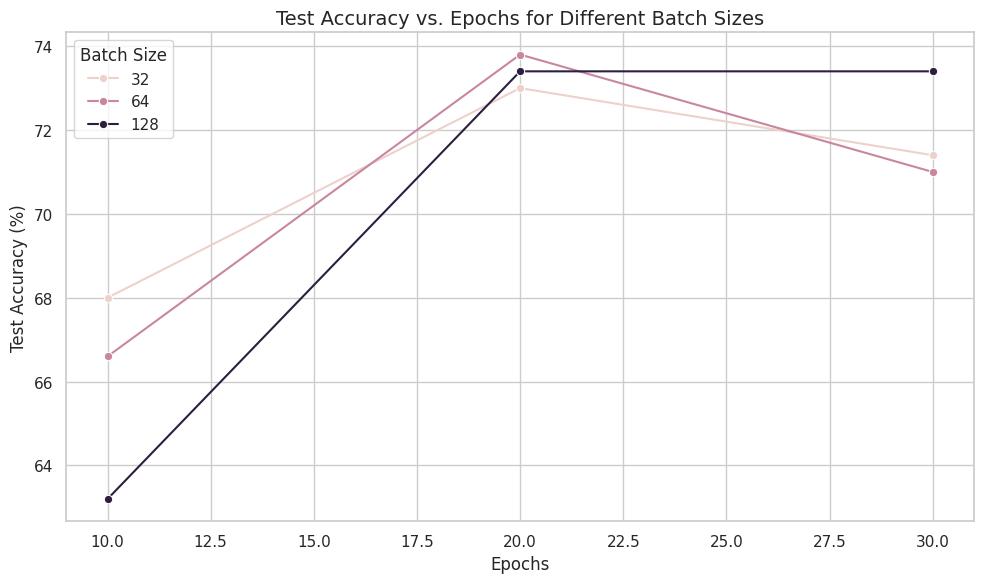

In [ ]:
df2 = pd.DataFrame(output, columns=["Batch Size", "Epochs", "Accuracy"])
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df2, x="Epochs", y="Accuracy", hue="Batch Size", marker="o")
plt.title("Test Accuracy vs. Epochs for Different Batch Sizes", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy (%)")
plt.legend(title="Batch Size")
plt.tight_layout()
plt.show()

---------------------------------------------
# Repeating the above experiment in (5) using a different CIFAR-100 subset
---------------------------------------------

# Data Loading, Preparation, and Preprocessing

In [ ]:
(x_train_2, y_train_2), (x_test_2, y_test_2) = tf.keras.datasets.cifar100.load_data()
CIFAR100_LABELS = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy',
    'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish',
    'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange',
    'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk',
    'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe',
    'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

In [ ]:
np.random.seed(44)  # To ensure reproducibility
#selected_classes_2 = np.random.choice(CIFAR100_LABELS, 10, replace=False)
selected_classes_2 = ['orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',]
print(f"Selected classes (another): {selected_classes_2}")

Selected classes (another): ['orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine']


In [ ]:
selected_class_indices_2 = map_classes_to_indices(selected_classes_2, CIFAR100_LABELS)

x_train_selected_2, y_train_selected_2 = extract_data_for_classes(x_train_2, y_train_2, selected_class_indices_2)
x_test_selected_2, y_test_selected_2 = extract_data_for_classes(x_test_2, y_test_2, selected_class_indices_2)

y_train_selected_2 = remap_labels(y_train_selected_2, selected_class_indices_2)
y_test_selected_2 = remap_labels(y_test_selected_2, selected_class_indices_2)

x_train_final_2, y_train_final_2 = reduce_dataset_size(x_train_selected_2, y_train_selected_2, 300)
x_test_final_2, y_test_final_2 = reduce_dataset_size(x_test_selected_2, y_test_selected_2, 50)

x_train_final_2, y_train_final_2 = preprocess_data(x_train_final_2, y_train_final_2, len(selected_classes_2))
x_test_final_2, y_test_final_2 = preprocess_data(x_test_final_2, y_test_final_2, len(selected_classes_2))

print(f"Train Data 2 Shape: {x_train_final_2.shape}, Train 2 Labels: {y_train_final_2.shape}")
print(f"Test Data 2 Shape: {x_test_final_2.shape}, Test 2 Labels: {y_test_final_2.shape}")

Train Data 2 Shape: (3000, 32, 32, 3), Train 2 Labels: (3000, 10)
Test Data 2 Shape: (500, 32, 32, 3), Test 2 Labels: (500, 10)


# Evaluating CNN model performance on Imagenet dataset

In [ ]:
cnn_model_2 = build_cnn_model()
cnn_model_2.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_186 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_187 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_100               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_188 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_189 (Conv2D)             │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_101               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_115 (Dropout)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_190 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_191 (Conv2D)             │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_102               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_116 (Dropout)           │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_33 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_117 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,341,226 (5.12 MB)

 Trainable params: 1,341,226 (5.12 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_2 = cnn_model_2.fit(x_train_final_2, y_train_final_2,
                    epochs=25,
                    batch_size=64,
                    validation_data=(x_test_final_2, y_test_final_2))

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy: 0.1609 - loss: 2.2207 - val_accuracy: 0.3140 - val_loss: 1.9502
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.3513 - loss: 1.8099 - val_accuracy: 0.4600 - val_loss: 1.5909
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4683 - loss: 1.5244 - val_accuracy: 0.4620 - val_loss: 1.4973
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5458 - loss: 1.3235 - val_accuracy: 0.5900 - val_loss: 1.1751
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6007 - loss: 1.1541 - val_accuracy: 0.6140 - val_loss: 1.1256
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6577 - loss: 0.9789 - val_accuracy: 0.6140 - val_loss: 1.1160
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6653 - loss: 0.9556 - val_accuracy: 0.6460 - val_loss: 1.1383
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6794 - loss: 0.9013 - val_accuracy: 0.6940 - val_

In [ ]:
test_loss_2, test_accuracy_2 = cnn_model_2.evaluate(x_test_final_2, y_test_final_2)
print(f"Accuracy 2: {test_accuracy_2 * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7602 - loss: 0.9817
Accuracy 2: 78.60%


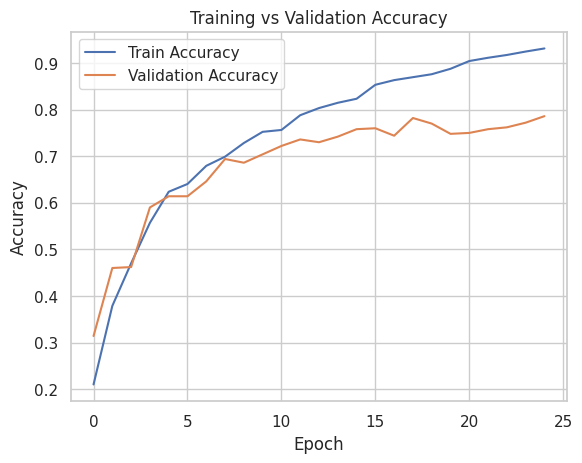

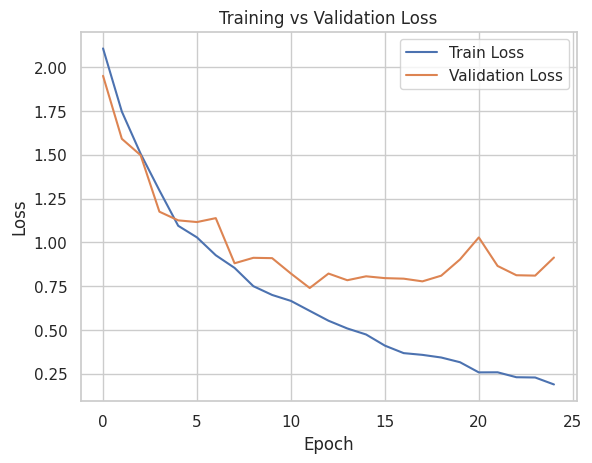

In [ ]:
plt.plot(history_2.history['accuracy'], label='Train Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

print("")
plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Experiments to Improve Accuracy

## 1. Increasing the size and depth of the inner layers

In [ ]:
deeper_model_2 = build_deeper_model()
deeper_history_2 = deeper_model_2.fit(x_train_final_2, y_train_final_2, epochs=25, batch_size=64, validation_data=(x_test_final_2, y_test_final_2))

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 232ms/step - accuracy: 0.1762 - loss: 4.0254 - val_accuracy: 0.1220 - val_loss: 4.0464
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.4038 - loss: 2.9934 - val_accuracy: 0.1820 - val_loss: 4.5909
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4668 - loss: 2.6949 - val_accuracy: 0.1700 - val_loss: 5.1643
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5393 - loss: 2.4502 - val_accuracy: 0.2280 - val_loss: 5.0480
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5403 - loss: 2.3224 - val_accuracy: 0.2040 - val_loss: 5.1775
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5853 - loss: 2.2159 - val_accuracy: 0.1960 - val_loss: 4.9994
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6156 - loss: 2.0632 - val_accuracy: 0.2440 - val_loss: 4.4710
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6286 - loss: 1.9534 - val_accuracy: 0.1940 -

In [ ]:
deeper_test_loss_2, deeper_test_accuracy_2 = deeper_model_2.evaluate(x_test_final_2, y_test_final_2)
print(f"Accuracy 2 after optimizations: {deeper_test_accuracy_2 * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7289 - loss: 1.3452
Accuracy 2 after optimizations: 74.40%


## 2. Using fewer or more convolutional/maxpooling layers and different shapes

In [ ]:
simpler_model_2 = build_simpler_model()
history_simple_2 = simpler_model_2.fit(x_train_final_2, y_train_final_2,
                                  epochs=25,
                                  batch_size=64,
                                  validation_data=(x_test_final_2, y_test_final_2))

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.2253 - loss: 2.1435 - val_accuracy: 0.4660 - val_loss: 1.5984
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4415 - loss: 1.6142 - val_accuracy: 0.5560 - val_loss: 1.3321
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5490 - loss: 1.3313 - val_accuracy: 0.6280 - val_loss: 1.1836
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6090 - loss: 1.1489 - val_accuracy: 0.6320 - val_loss: 1.1205
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6315 - loss: 1.0875 - val_accuracy: 0.6560 - val_loss: 1.0216
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6449 - loss: 0.9786 - val_accuracy: 0.6900 - val_loss: 0.9562
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7070 - loss: 0.8482 - val_accuracy: 0.6520 - val_loss: 1.0085
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7145 - loss: 0.8412 - val_accuracy: 0.6960 - val_loss

In [ ]:
simpler_test_loss_2, simpler_test_accuracy_2 = simpler_model_2.evaluate(x_test_final_2, y_test_final_2)
print(f"Accuracy (simpler_2): {simpler_test_accuracy_2 * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7362 - loss: 0.7708
Accuracy (simpler_2): 75.80%


In [ ]:
deep_model_2 = build_deep_model()
history_deep_2 = deep_model_2.fit(x_train_final_2, y_train_final_2,
                                  epochs=25,
                                  batch_size=64,
                                  validation_data=(x_test_final_2, y_test_final_2))

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.1692 - loss: 2.1823 - val_accuracy: 0.3260 - val_loss: 1.8377
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3543 - loss: 1.7598 - val_accuracy: 0.4940 - val_loss: 1.5281
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5075 - loss: 1.3951 - val_accuracy: 0.5580 - val_loss: 1.2674
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6029 - loss: 1.1212 - val_accuracy: 0.6360 - val_loss: 1.0605
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6628 - loss: 0.9507 - val_accuracy: 0.6360 - val_loss: 1.1703
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6893 - loss: 0.8867 - val_accuracy: 0.6580 - val_loss: 1.0602
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7202 - loss: 0.7919 - val_accuracy: 0.7240 - val_loss: 0.9129
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7741 - loss: 0.6300 - val_accuracy: 0.7140 - v

In [ ]:
deep_test_loss_2, deep_test_accuracy_2 = deep_model_2.evaluate(x_test_final_2, y_test_final_2)
print(f"Accuracy (deep_2): {deep_test_accuracy_2 * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7720 - loss: 1.1340
Accuracy (deep_2): 78.20%


## 3. Using different activation functions in the inner layers and in the convolutional layers

In [ ]:
tanh_model_2 = cnn_with_tanh()
tanh_history_2 = tanh_model_2.fit(x_train_final_2, y_train_final_2,
                                  epochs=25,
                                  batch_size=64,
                                  validation_data=(x_test_final_2, y_test_final_2))

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.3375 - loss: 1.8777 - val_accuracy: 0.5860 - val_loss: 1.2923
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6066 - loss: 1.1578 - val_accuracy: 0.6180 - val_loss: 1.0957
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6890 - loss: 0.9644 - val_accuracy: 0.6640 - val_loss: 1.0171
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7138 - loss: 0.8276 - val_accuracy: 0.6900 - val_loss: 0.9223
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7865 - loss: 0.6489 - val_accuracy: 0.7000 - val_loss: 0.8811
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7985 - loss: 0.5738 - val_accuracy: 0.7600 - val_loss: 0.7828
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8542 - loss: 0.4411 - val_accuracy: 0.7740 - val_loss: 0.7257
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8915 - loss: 0.3446 - val_accuracy: 0.7500 - val_loss

In [ ]:
tanh_test_loss_2, tanh_test_accuracy_2 = tanh_model_2.evaluate(x_test_final_2, y_test_final_2)
print(f"Accuracy (tanh_2): {tanh_test_accuracy_2 * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7709 - loss: 0.8775
Accuracy (tanh_2): 78.40%


In [ ]:
sigmoid_model_2 = cnn_with_sigmoid()
sigmoid_history_2 = sigmoid_model_2.fit(x_train_final_2, y_train_final_2,
                                  epochs=25,
                                  batch_size=64,
                                  validation_data=(x_test_final_2, y_test_final_2))

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.0995 - loss: 2.4848 - val_accuracy: 0.1000 - val_loss: 2.3178
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1009 - loss: 2.3234 - val_accuracy: 0.1040 - val_loss: 2.3145
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1001 - loss: 2.3150 - val_accuracy: 0.1280 - val_loss: 2.2974
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1267 - loss: 2.2857 - val_accuracy: 0.1800 - val_loss: 2.2194
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2258 - loss: 2.1183 - val_accuracy: 0.3440 - val_loss: 1.9155
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3822 - loss: 1.8004 - val_accuracy: 0.3480 - val_loss: 1.8607
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3890 - loss: 1.7568 - val_accuracy: 0.4100 - val_loss: 1.7588
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4279 - loss: 1.6680 - val_accuracy: 0.4120 - val_loss

In [ ]:
sigmoid_test_loss_2, sigmoid_test_accuracy_2 = sigmoid_model_2.evaluate(x_test_final_2, y_test_final_2)
print(f"Accuracy (sigmoid_2): {sigmoid_test_accuracy_2 * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5471 - loss: 1.2622
Accuracy (sigmoid_2): 57.60%


In [ ]:
leaky_relu_model_2 = cnn_with_leaky_relu()
leaky_relu_history_2 = leaky_relu_model_2.fit(x_train_final_2, y_train_final_2,
                                  epochs=25,
                                  batch_size=64,
                                  validation_data=(x_test_final_2, y_test_final_2))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - accuracy: 0.1457 - loss: 2.2167 - val_accuracy: 0.3300 - val_loss: 1.8547
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.3798 - loss: 1.7001 - val_accuracy: 0.5180 - val_loss: 1.3768
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5234 - loss: 1.3296 - val_accuracy: 0.5720 - val_loss: 1.3013
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6043 - loss: 1.1268 - val_accuracy: 0.6300 - val_loss: 1.0452
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6491 - loss: 0.9543 - val_accuracy: 0.6680 - val_loss: 0.9895
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6969 - loss: 0.8468 - val_accuracy: 0.7000 - val_loss: 0.8826
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7353 - loss: 0.7429 - val_accuracy: 0.7040 - val_loss: 0.8957
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7448 - loss: 0.6893 - val_accuracy: 0.7260 - val_l

In [ ]:
leaky_relu_test_loss_2, leaky_relu_test_accuracy_2 = leaky_relu_model_2.evaluate(x_test_final_2, y_test_final_2)
print(f"Accuracy (leaky_relu_2): {leaky_relu_test_accuracy_2 * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7729 - loss: 0.9046
Accuracy (leaky_relu_2): 79.00%


In [ ]:
swish_model_2 = cnn_with_swish()
swish_history_2 = swish_model_2.fit(x_train_final_2, y_train_final_2,
                                  epochs=25,
                                  batch_size=64,
                                  validation_data=(x_test_final_2, y_test_final_2))

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.2481 - loss: 2.0546 - val_accuracy: 0.4820 - val_loss: 1.5302
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5415 - loss: 1.3523 - val_accuracy: 0.5960 - val_loss: 1.2534
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6157 - loss: 1.1321 - val_accuracy: 0.6080 - val_loss: 1.1457
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6315 - loss: 1.0159 - val_accuracy: 0.6440 - val_loss: 1.0635
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6869 - loss: 0.8807 - val_accuracy: 0.6420 - val_loss: 0.9908
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7028 - loss: 0.8296 - val_accuracy: 0.6560 - val_loss: 1.0118
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7283 - loss: 0.7866 - val_accuracy: 0.6620 - val_loss: 0.9385
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7628 - loss: 0.6668 - val_accuracy: 0.6920 - val_loss

In [ ]:
swish_test_loss_2, swish_test_accuracy_2 = swish_model_2.evaluate(x_test_final_2, y_test_final_2)
print(f"Accuracy (swish_2): {swish_test_accuracy_2 * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7104 - loss: 1.7785
Accuracy (swish_2): 73.60%


In [ ]:
relu_model_2 = cnn_with_relu()
relu_history_2 = relu_model_2.fit(x_train_final_2, y_train_final_2,
                                  epochs=25,
                                  batch_size=64,
                                  validation_data=(x_test_final_2, y_test_final_2))

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.2140 - loss: 2.1583 - val_accuracy: 0.4220 - val_loss: 1.6019
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4832 - loss: 1.4602 - val_accuracy: 0.5840 - val_loss: 1.3057
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5850 - loss: 1.2119 - val_accuracy: 0.5980 - val_loss: 1.2295
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6193 - loss: 1.0539 - val_accuracy: 0.6420 - val_loss: 1.0983
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6818 - loss: 0.9056 - val_accuracy: 0.6460 - val_loss: 1.0338
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7288 - loss: 0.7642 - val_accuracy: 0.7160 - val_loss: 0.8596
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7649 - loss: 0.6789 - val_accuracy: 0.6820 - val_loss: 0.9837
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7897 - loss: 0.5990 - val_accuracy: 0.7200 - val_loss

In [ ]:
relu_test_loss_2, relu_test_accuracy_2 = relu_model_2.evaluate(x_test_final_2, y_test_final_2)
print(f"Accuracy (relu_2): {relu_test_accuracy_2 * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7561 - loss: 1.1930
Accuracy (relu_2): 76.60%


In [ ]:
swish_and_relu_model_2 = cnn_with_swish_and_relu()
swish_and_relu_history_2 = swish_and_relu_model_2.fit(x_train_final_2, y_train_final_2,
                                  epochs=25,
                                  batch_size=64,
                                  validation_data=(x_test_final_2, y_test_final_2))

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - accuracy: 0.1752 - loss: 2.2003 - val_accuracy: 0.3380 - val_loss: 1.8792
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3799 - loss: 1.7316 - val_accuracy: 0.5120 - val_loss: 1.4768
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5080 - loss: 1.3992 - val_accuracy: 0.5720 - val_loss: 1.2125
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5778 - loss: 1.1925 - val_accuracy: 0.6040 - val_loss: 1.1369
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6150 - loss: 1.1104 - val_accuracy: 0.6440 - val_loss: 1.0427
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6824 - loss: 0.9113 - val_accuracy: 0.7000 - val_loss: 0.9303
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7253 - loss: 0.7951 - val_accuracy: 0.7060 - val_loss: 0.9624
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7661 - loss: 0.6666 - val_accuracy: 0.7020 - val_l

In [ ]:
swish_and_relu_test_loss_2, swish_and_relu_test_accuracy_2 = swish_and_relu_model_2.evaluate(x_test_final_2, y_test_final_2)
print(f"Accuracy (swish_and_relu_2): {swish_and_relu_test_accuracy_2 * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7411 - loss: 0.8395
Accuracy (swish_and_relu_2): 78.00%


In [ ]:
swish_and_leaky_relu_model_2 = cnn_with_swish_and_leaky_relu()
swish_and_leaky_relu_history_2 = swish_and_leaky_relu_model_2.fit(x_train_final_2, y_train_final_2,
                                  epochs=25,
                                  batch_size=64,
                                  validation_data=(x_test_final_2, y_test_final_2))

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.2315 - loss: 2.0706 - val_accuracy: 0.4600 - val_loss: 1.6234
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4902 - loss: 1.4648 - val_accuracy: 0.5380 - val_loss: 1.3593
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5865 - loss: 1.2063 - val_accuracy: 0.6420 - val_loss: 1.1143
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6692 - loss: 0.9578 - val_accuracy: 0.6420 - val_loss: 0.9910
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7080 - loss: 0.8426 - val_accuracy: 0.7220 - val_loss: 0.8826
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7258 - loss: 0.7635 - val_accuracy: 0.7020 - val_loss: 0.8308
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7826 - loss: 0.6326 - val_accuracy: 0.7480 - val_loss: 0.7582
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7969 - loss: 0.5831 - val_accuracy: 0.7020 - val_l

In [ ]:
swish_and_leaky_relu_test_loss_2, swish_and_leaky_relu_test_accuracy_2 = swish_and_leaky_relu_model_2.evaluate(x_test_final_2, y_test_final_2)
print(f"Accuracy (swish_and_leaky_relu_2): {swish_and_leaky_relu_test_accuracy_2 * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7867 - loss: 0.6984
Accuracy (swish_and_leaky_relu_2): 79.60%


## 4. Using various optimizers and learning rate

In [ ]:
results_2 = []
for opt_name, opt_class in optimizers.items():
    for lr in learning_rates:
        print(f"\nTesting {opt_name} with learning rate {lr}")
        model = build_model()
        optimizer = opt_class(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(
            x_train_final_2, y_train_final_2,
            epochs=25,
            batch_size=64,
            validation_data=(x_test_final_2, y_test_final_2)
        )

        test_loss, test_acc = model.evaluate(x_test_final_2, y_test_final_2, verbose=0)
        print(f"Accuracy: {test_acc * 100:.2f}%")
        results_2.append((opt_name, lr, test_acc * 100))


Testing Adam with learning rate 0.01
Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.1132 - loss: 2.3506 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1082 - loss: 2.3032 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0939 - loss: 2.3029 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1083 - loss: 2.3036 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0881 - loss: 2.3040 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1011 - loss: 2.3033 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1039 - loss: 2.3032 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0989 - loss:

In [ ]:
print("Summary of results:")
for opt_name, lr, acc in results_2:
    print(f"{opt_name} (lr={lr}) → Accuracy: {acc:.2f}%")

Summary of results:
Adam (lr=0.01) → Accuracy: 10.00%
Adam (lr=0.001) → Accuracy: 76.00%
Adam (lr=0.0001) → Accuracy: 67.20%
SGD (lr=0.01) → Accuracy: 48.00%
SGD (lr=0.001) → Accuracy: 12.00%
SGD (lr=0.0001) → Accuracy: 10.00%
RMSprop (lr=0.01) → Accuracy: 10.00%
RMSprop (lr=0.001) → Accuracy: 74.00%
RMSprop (lr=0.0001) → Accuracy: 61.00%
Adagrad (lr=0.01) → Accuracy: 63.20%
Adagrad (lr=0.001) → Accuracy: 18.80%
Adagrad (lr=0.0001) → Accuracy: 14.40%


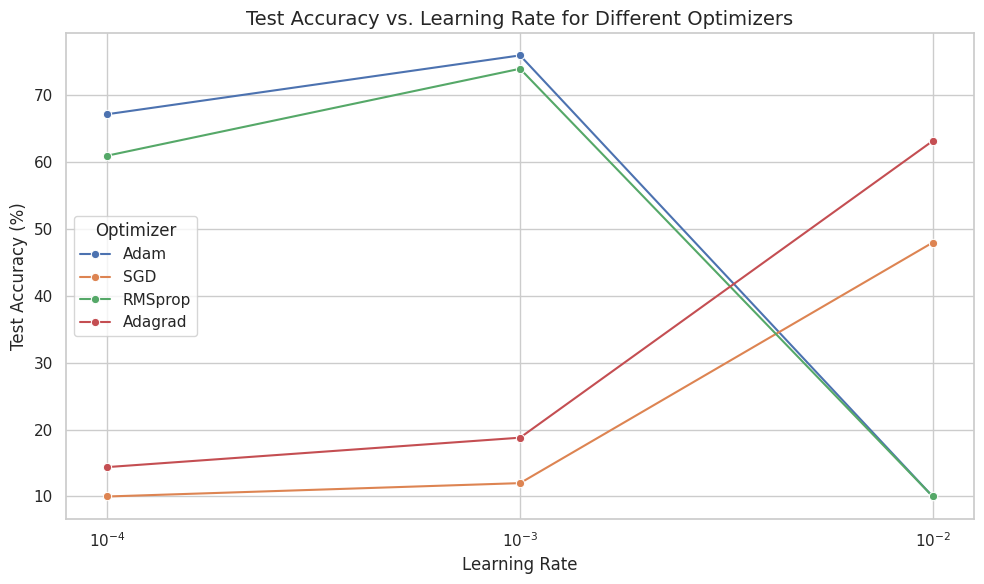

In [ ]:
df_2 = pd.DataFrame(results_2, columns=["Optimizer", "Learning Rate", "Accuracy"])
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_2, x="Learning Rate", y="Accuracy", hue="Optimizer", marker="o")
plt.title("Test Accuracy vs. Learning Rate for Different Optimizers", fontsize=14)
plt.xlabel("Learning Rate")
plt.ylabel("Test Accuracy (%)")
plt.legend(title="Optimizer")
plt.xscale("log")
plt.tight_layout()
plt.show()

## 5. Using various batch sizes and epochs for training

In [ ]:
output_2 = []

for batch_size in batch_sizes:
    for num_epochs in epochs_list:
        print(f"\nTraining with batch size {batch_size} and epochs {num_epochs}")

        model = build_model()
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(
            x_train_final_2, y_train_final_2,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_test_final_2, y_test_final_2)
        )

        test_loss, test_acc = model.evaluate(x_test_final_2, y_test_final_2, verbose=0)
        print(f"Accuracy: {test_acc * 100:.2f}%")
        output_2.append((batch_size, num_epochs, test_acc * 100))


Training with batch size 32 and epochs 10
Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.1787 - loss: 2.1999 - val_accuracy: 0.3300 - val_loss: 1.8950
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3734 - loss: 1.7063 - val_accuracy: 0.4900 - val_loss: 1.3634
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5220 - loss: 1.3748 - val_accuracy: 0.5620 - val_loss: 1.2145
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6301 - loss: 1.0678 - val_accuracy: 0.6540 - val_loss: 1.1036
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6567 - loss: 0.9933 - val_accuracy: 0.6360 - val_loss: 1.0342
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7058 - loss: 0.8584 - val_accuracy: 0.6760 - val_loss: 0.9713
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7164 - loss: 0.8081 - val_accuracy: 0.7100 - val_loss: 0.9097
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7533 - lo

In [ ]:
print("Summary of batch size and epoch experiments:")
for batch_size, num_epochs, acc in output_2:
    print(f"Batch Size: {batch_size}, Epochs: {num_epochs} → Accuracy: {acc:.2f}%")

Summary of batch size and epoch experiments:
Batch Size: 32, Epochs: 10 → Accuracy: 72.40%
Batch Size: 32, Epochs: 20 → Accuracy: 72.80%
Batch Size: 32, Epochs: 30 → Accuracy: 74.80%
Batch Size: 64, Epochs: 10 → Accuracy: 69.80%
Batch Size: 64, Epochs: 20 → Accuracy: 75.20%
Batch Size: 64, Epochs: 30 → Accuracy: 74.40%
Batch Size: 128, Epochs: 10 → Accuracy: 66.20%
Batch Size: 128, Epochs: 20 → Accuracy: 74.00%
Batch Size: 128, Epochs: 30 → Accuracy: 74.20%


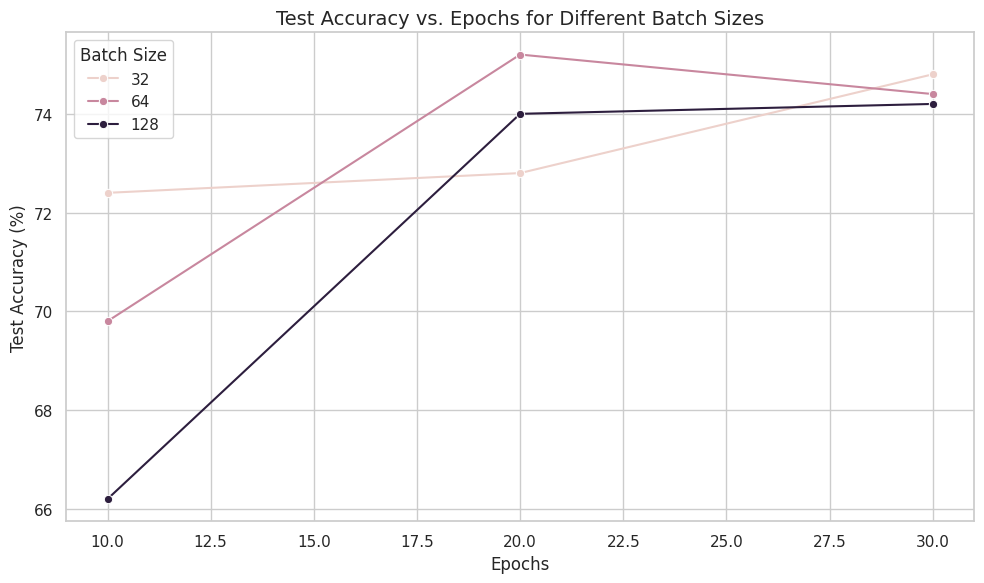

In [ ]:
df_batch_2 = pd.DataFrame(output_2, columns=["Batch Size", "Epochs", "Accuracy"])
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_batch_2, x="Epochs", y="Accuracy", hue="Batch Size", marker="o")
plt.title("Test Accuracy vs. Epochs for Different Batch Sizes", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy (%)")
plt.legend(title="Batch Size")
plt.tight_layout()
plt.show()

--------------------------------------------
# Repeating the above experiment in (5) using a subset of the imagenet data set (8-12 classes, a random subset from each class of suitable size)
--------------------------------------------

# Data Loading, Preparation, and Preprocessing

In [ ]:
dataset_name = "imagenette/320px"
(train_ds, val_ds), ds_info = tfds.load(dataset_name, split=['train', 'validation'], as_supervised=True, with_info=True)
class_names = ds_info.features['label'].names

# Selecting a random subset of classes
np.random.seed(42)
selected_class_indices = np.random.choice(range(len(class_names)), 10, replace=False)
selected_class_names = [class_names[i] for i in selected_class_indices]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/320px/incomplete.60GZ3Z_1.0.0/imagenette-train.tfrecord*...:   …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/320px/incomplete.60GZ3Z_1.0.0/imagenette-validation.tfrecord*..…

Dataset imagenette downloaded and prepared to /root/tensorflow_datasets/imagenette/320px/1.0.0. Subsequent calls will reuse this data.


In [ ]:
def filter_and_remap(dataset, selected_indices, samples_per_class, image_size=(32, 32)):
    class_counts = {i: 0 for i in range(len(selected_indices))}
    selected_images = []
    selected_labels = []

    for image, label in tfds.as_numpy(dataset):
        if label in selected_indices:
            new_label = selected_indices.tolist().index(label)

            if class_counts[new_label] < samples_per_class:
                image = tf.image.resize(image, image_size).numpy().astype('float32') / 255.0
                selected_images.append(image)
                selected_labels.append(new_label)
                class_counts[new_label] += 1

        if all(v >= samples_per_class for v in class_counts.values()):
            break

    return np.array(selected_images), np.array(selected_labels)

x_train_3, y_train_3 = filter_and_remap(train_ds, selected_class_indices, samples_per_class=300)
x_val_3, y_val_3 = filter_and_remap(val_ds, selected_class_indices, samples_per_class=50)

y_train_3 = to_categorical(y_train_3, num_classes=10)
y_val_3 = to_categorical(y_val_3, num_classes=10)

print(f"Train shape: {x_train_3.shape}, Labels: {y_train_3.shape}")
print(f"Val shape: {x_val_3.shape}, Labels: {y_val_3.shape}")

Train shape: (3000, 32, 32, 3), Labels: (3000, 10)
Val shape: (500, 32, 32, 3), Labels: (500, 10)


# Evaluating CNN model performance on Imagenet dataset

In [ ]:
cnn_model_3 = build_cnn_model()
cnn_model_3.summary()

Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_364 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_365 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_196               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_222 (Dropout)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_366 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_367 (Conv2D)             │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_197               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_223 (Dropout)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_368 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_369 (Conv2D)             │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_198               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_224 (Dropout)           │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_65 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_225 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,341,226 (5.12 MB)

 Trainable params: 1,341,226 (5.12 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_3 = cnn_model_3.fit(
    x_train_3, y_train_3,
    epochs=25,
    batch_size=64,
    validation_data=(x_val_3, y_val_3)
)

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - accuracy: 0.0979 - loss: 2.3084 - val_accuracy: 0.2900 - val_loss: 2.2649
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1996 - loss: 2.1960 - val_accuracy: 0.2700 - val_loss: 2.0274
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2523 - loss: 2.0515 - val_accuracy: 0.3080 - val_loss: 1.9286
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2772 - loss: 1.9885 - val_accuracy: 0.3500 - val_loss: 1.8645
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3084 - loss: 1.9257 - val_accuracy: 0.4260 - val_loss: 1.7426
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3987 - loss: 1.7333 - val_accuracy: 0.4180 - val_loss: 1.7242
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4066 - loss: 1.6850 - val_accuracy: 0.5180 - val_loss: 1.5426
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4845 - loss: 1.5451 - val_accuracy: 0.5140 - val_l

In [ ]:
test_loss_3, test_accuracy_3 = cnn_model_3.evaluate(x_val_3, y_val_3)
print(f"Accuracy: {test_accuracy_3 * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6281 - loss: 1.6697
Accuracy: 63.80%


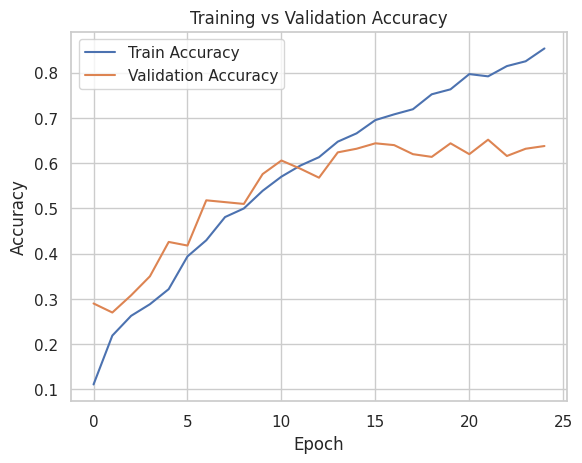

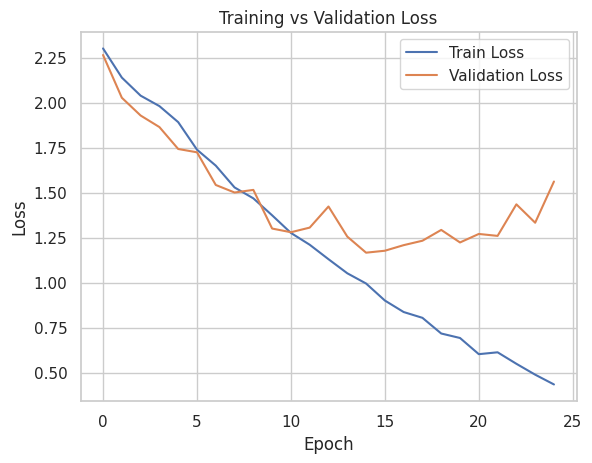

In [ ]:
plt.plot(history_3.history['accuracy'], label='Train Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

print("")
plt.plot(history_3.history['loss'], label='Train Loss')
plt.plot(history_3.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Experiments to improve accuracy

## 1. Increasing the size and depth of the inner layers

In [ ]:
deeper_model_3 = build_deeper_model()
deeper_history_3 = deeper_model_3.fit(x_train_3, y_train_3, epochs=25, batch_size=64, validation_data=(x_val_3, y_val_3))

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 225ms/step - accuracy: 0.1345 - loss: 4.2565 - val_accuracy: 0.1000 - val_loss: 6.1250
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.2278 - loss: 3.5457 - val_accuracy: 0.1440 - val_loss: 6.2362
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3061 - loss: 3.1988 - val_accuracy: 0.1060 - val_loss: 5.4652
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.3504 - loss: 3.0234 - val_accuracy: 0.1700 - val_loss: 4.7983
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3928 - loss: 2.8559 - val_accuracy: 0.1760 - val_loss: 3.7548
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4130 - loss: 2.7547 - val_accuracy: 0.1620 - val_loss: 4.2267
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4787 - loss: 2.5449 - val_accuracy: 0.1800 - val_loss: 3.8638
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5255 - loss: 2.3710 - val_accuracy: 0.3360 -

In [ ]:
deeper_test_loss_3, deeper_test_accuracy_3 = deeper_model_3.evaluate(x_val_3, y_val_3)
print(f"Accuracy after optimizations: {deeper_test_accuracy_3 * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6185 - loss: 1.8820
Accuracy after optimizations: 63.60%


## 2. Using fewer or more convolutional/maxpooling layers and different shapes

In [ ]:
simpler_model_3 = build_simpler_model()
history_simple_3 = simpler_model_3.fit(x_train_3, y_train_3,
                                  epochs=25,
                                  batch_size=64,
                                  validation_data=(x_val_3, y_val_3))

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.1765 - loss: 2.2368 - val_accuracy: 0.4160 - val_loss: 1.8255
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3814 - loss: 1.8262 - val_accuracy: 0.4980 - val_loss: 1.6221
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4476 - loss: 1.6236 - val_accuracy: 0.4960 - val_loss: 1.5461
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4970 - loss: 1.4969 - val_accuracy: 0.5200 - val_loss: 1.4330
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5563 - loss: 1.3396 - val_accuracy: 0.5480 - val_loss: 1.4202
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5799 - loss: 1.2816 - val_accuracy: 0.5900 - val_loss: 1.2667
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6413 - loss: 1.1053 - val_accuracy: 0.6040 - val_loss: 1.2197
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6720 - loss: 0.9904 - val_accuracy: 0.5780 - val_loss

In [ ]:
simpler_test_loss_3, simpler_test_accuracy_3 = simpler_model_3.evaluate(x_val_3, y_val_3)
print(f"Accuracy (simpler_3): {simpler_test_accuracy_3 * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5963 - loss: 1.6579
Accuracy (simpler_3): 60.20%


In [ ]:
deep_model_3 = build_deep_model()
history_deep_3 = deep_model_3.fit(x_train_3, y_train_3,
                                  epochs=25,
                                  batch_size=64,
                                  validation_data=(x_val_3, y_val_3))

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.0910 - loss: 2.3054 - val_accuracy: 0.1780 - val_loss: 2.2568
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1920 - loss: 2.1902 - val_accuracy: 0.3120 - val_loss: 1.9891
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2662 - loss: 2.0216 - val_accuracy: 0.3360 - val_loss: 1.8647
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2968 - loss: 1.9441 - val_accuracy: 0.4040 - val_loss: 1.7719
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3845 - loss: 1.7730 - val_accuracy: 0.4060 - val_loss: 1.7487
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4159 - loss: 1.6443 - val_accuracy: 0.4440 - val_loss: 1.6137
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4730 - loss: 1.5037 - val_accuracy: 0.5580 - val_loss: 1.3985
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5658 - loss: 1.3080 - val_accuracy: 0.5620 - v

In [ ]:
deep_test_loss_3, deep_test_accuracy_3 = deep_model_3.evaluate(x_val_3, y_val_3)
print(f"Accuracy (deep_3): {deep_test_accuracy_3 * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6023 - loss: 2.3864
Accuracy (deep_3): 59.60%


## 3. Using different activation functions in the inner layers and in the convolutional layers

In [ ]:
tanh_model_3 = cnn_with_tanh()
tanh_history_3 = tanh_model_3.fit(x_train_3, y_train_3,
                                  epochs=25,
                                  batch_size=64,
                                  validation_data=(x_val_3, y_val_3))

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.2328 - loss: 2.1621 - val_accuracy: 0.4660 - val_loss: 1.6314
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4569 - loss: 1.6080 - val_accuracy: 0.4780 - val_loss: 1.5059
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5493 - loss: 1.3928 - val_accuracy: 0.6020 - val_loss: 1.2786
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6107 - loss: 1.1862 - val_accuracy: 0.5920 - val_loss: 1.3072
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6868 - loss: 0.9883 - val_accuracy: 0.5860 - val_loss: 1.2735
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7369 - loss: 0.8384 - val_accuracy: 0.5980 - val_loss: 1.2615
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7886 - loss: 0.6793 - val_accuracy: 0.6060 - val_loss: 1.2226
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8640 - loss: 0.4853 - val_accuracy: 0.6000 - val_loss

In [ ]:
tanh_test_loss_3, tanh_test_accuracy_3 = tanh_model_3.evaluate(x_val_3, y_val_3)
print(f"Accuracy (tanh_3): {tanh_test_accuracy_3 * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6304 - loss: 1.8729
Accuracy (tanh_3): 61.40%


In [ ]:
sigmoid_model_3 = cnn_with_sigmoid()
sigmoid_history_3 = sigmoid_model_3.fit(x_train_3, y_train_3,
                                  epochs=25,
                                  batch_size=64,
                                  validation_data=(x_val_3, y_val_3))

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.0902 - loss: 2.4781 - val_accuracy: 0.1000 - val_loss: 2.3162
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0954 - loss: 2.3250 - val_accuracy: 0.1000 - val_loss: 2.3194
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1026 - loss: 2.3245 - val_accuracy: 0.1000 - val_loss: 2.3050
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0895 - loss: 2.3190 - val_accuracy: 0.1100 - val_loss: 2.3104
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0997 - loss: 2.3145 - val_accuracy: 0.1000 - val_loss: 2.2985
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1214 - loss: 2.2995 - val_accuracy: 0.1560 - val_loss: 2.2715
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1503 - loss: 2.2719 - val_accuracy: 0.1820 - val_loss: 2.1584
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2040 - loss: 2.1687 - val_accuracy: 0.2680 - val_loss

In [ ]:
sigmoid_test_loss_3, sigmoid_test_accuracy_3 = sigmoid_model_3.evaluate(x_val_3, y_val_3)
print(f"Accuracy (sigmoid_3): {sigmoid_test_accuracy_3 * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4048 - loss: 1.7824
Accuracy (sigmoid_3): 38.40%


In [ ]:
leaky_relu_model_3 = cnn_with_leaky_relu()
leaky_relu_history_3 = leaky_relu_model_3.fit(x_train_3, y_train_3,
                                  epochs=25,
                                  batch_size=64,
                                  validation_data=(x_val_3, y_val_3))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.1318 - loss: 2.2679 - val_accuracy: 0.3300 - val_loss: 1.9015
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2835 - loss: 1.9989 - val_accuracy: 0.4360 - val_loss: 1.7763
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3905 - loss: 1.7689 - val_accuracy: 0.4680 - val_loss: 1.5918
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4527 - loss: 1.5638 - val_accuracy: 0.5040 - val_loss: 1.4711
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4632 - loss: 1.5176 - val_accuracy: 0.5380 - val_loss: 1.4064
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5408 - loss: 1.3736 - val_accuracy: 0.5660 - val_loss: 1.3188
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5700 - loss: 1.2337 - val_accuracy: 0.5620 - val_loss: 1.3381
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6322 - loss: 1.0847 - val_accuracy: 0.5880 - val_l

In [ ]:
leaky_relu_test_loss_3, leaky_relu_test_accuracy_3 = leaky_relu_model_3.evaluate(x_val_3, y_val_3)
print(f"Accuracy (leaky_relu_3): {leaky_relu_test_accuracy_3 * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6175 - loss: 1.9260
Accuracy (leaky_relu_3): 61.00%


In [ ]:
swish_model_3 = cnn_with_swish()
swish_history_3 = swish_model_3.fit(x_train_3, y_train_3,
                                  epochs=25,
                                  batch_size=64,
                                  validation_data=(x_val_3, y_val_3))

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.1732 - loss: 2.2224 - val_accuracy: 0.3840 - val_loss: 1.7911
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3734 - loss: 1.8189 - val_accuracy: 0.4500 - val_loss: 1.6068
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4582 - loss: 1.6281 - val_accuracy: 0.4840 - val_loss: 1.5275
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4735 - loss: 1.5055 - val_accuracy: 0.5220 - val_loss: 1.4327
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5438 - loss: 1.3245 - val_accuracy: 0.5400 - val_loss: 1.4324
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5728 - loss: 1.2417 - val_accuracy: 0.5720 - val_loss: 1.3429
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6428 - loss: 1.0811 - val_accuracy: 0.5820 - val_loss: 1.3148
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6704 - loss: 0.9634 - val_accuracy: 0.5860 - val_loss

In [ ]:
swish_test_loss_3, swish_test_accuracy_3 = swish_model_3.evaluate(x_val_3, y_val_3)
print(f"Accuracy (swish_3): {swish_test_accuracy_3 * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5916 - loss: 3.0279
Accuracy (swish_3): 57.40%


In [ ]:
relu_model_3 = cnn_with_relu()
relu_history_3 = relu_model_3.fit(x_train_3, y_train_3,
                                  epochs=25,
                                  batch_size=64,
                                  validation_data=(x_val_3, y_val_3))

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.1548 - loss: 2.2660 - val_accuracy: 0.3500 - val_loss: 1.8669
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3500 - loss: 1.8753 - val_accuracy: 0.4480 - val_loss: 1.6141
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4549 - loss: 1.5923 - val_accuracy: 0.4640 - val_loss: 1.4852
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5176 - loss: 1.4307 - val_accuracy: 0.5520 - val_loss: 1.3639
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5729 - loss: 1.2502 - val_accuracy: 0.5260 - val_loss: 1.4855
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6131 - loss: 1.1651 - val_accuracy: 0.5860 - val_loss: 1.2861
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6471 - loss: 1.0494 - val_accuracy: 0.6280 - val_loss: 1.2464
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6964 - loss: 0.9164 - val_accuracy: 0.5960 - val_loss

In [ ]:
relu_test_loss_3, relu_test_accuracy_3 = relu_model_3.evaluate(x_val_3, y_val_3)
print(f"Accuracy (relu_3): {relu_test_accuracy_3 * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6554 - loss: 2.4873
Accuracy (relu_3): 64.80%


In [ ]:
swish_and_relu_model_3 = cnn_with_swish_and_relu()
swish_and_relu_history_3 = swish_and_relu_model_3.fit(x_train_3, y_train_3,
                                  epochs=25,
                                  batch_size=64,
                                  validation_data=(x_val_3, y_val_3))

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.1281 - loss: 2.2749 - val_accuracy: 0.3100 - val_loss: 1.8873
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2834 - loss: 1.9900 - val_accuracy: 0.4100 - val_loss: 1.7549
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3709 - loss: 1.8300 - val_accuracy: 0.4280 - val_loss: 1.6407
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3877 - loss: 1.7277 - val_accuracy: 0.4780 - val_loss: 1.5420
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4720 - loss: 1.5182 - val_accuracy: 0.5180 - val_loss: 1.4440
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5145 - loss: 1.4275 - val_accuracy: 0.5540 - val_loss: 1.3336
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5768 - loss: 1.2300 - val_accuracy: 0.6240 - val_loss: 1.2170
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6116 - loss: 1.1141 - val_accuracy: 0.5800 - val_l

In [ ]:
swish_and_relu_test_loss_3, swish_and_relu_test_accuracy_3 = swish_and_relu_model_3.evaluate(x_val_3, y_val_3)
print(f"Accuracy (swish_and_relu_3): {swish_and_relu_test_accuracy_3 * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6111 - loss: 1.6087
Accuracy (swish_and_relu_3): 62.80%


In [ ]:
swish_and_leaky_relu_model_3 = cnn_with_swish_and_leaky_relu()
swish_and_leaky_relu_history_3 = swish_and_leaky_relu_model_3.fit(x_train_3, y_train_3,
                                  epochs=25,
                                  batch_size=64,
                                  validation_data=(x_val_3, y_val_3))

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.1721 - loss: 2.2105 - val_accuracy: 0.3200 - val_loss: 1.8188
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3334 - loss: 1.8841 - val_accuracy: 0.4280 - val_loss: 1.6433
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4173 - loss: 1.6851 - val_accuracy: 0.4820 - val_loss: 1.5960
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4868 - loss: 1.5102 - val_accuracy: 0.5320 - val_loss: 1.4430
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5306 - loss: 1.3703 - val_accuracy: 0.5480 - val_loss: 1.3546
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5854 - loss: 1.2537 - val_accuracy: 0.5920 - val_loss: 1.2769
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6313 - loss: 1.0956 - val_accuracy: 0.6000 - val_loss: 1.2846
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7003 - loss: 0.9253 - val_accuracy: 0.6040 - val_lo

In [ ]:
swish_and_leaky_relu_test_loss_3, swish_and_leaky_relu_test_accuracy_3 = swish_and_leaky_relu_model_3.evaluate(x_val_3, y_val_3)
print(f"Accuracy (swish_and_leaky_relu_3): {swish_and_leaky_relu_test_accuracy_3 * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6038 - loss: 1.8809
Accuracy (swish_and_leaky_relu_3): 60.60%


## 4. Using various optimizers and learning rate

In [ ]:
results_3 = []
for opt_name, opt_class in optimizers.items():
    for lr in learning_rates:
        print(f"\nTesting {opt_name} with learning rate {lr}")
        model = build_model()
        optimizer = opt_class(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(
            x_train_final_2, y_train_final_2,
            epochs=25,
            batch_size=64,
            validation_data=(x_test_final_2, y_test_final_2)
        )

        test_loss, test_acc = model.evaluate(x_test_final_2, y_test_final_2, verbose=0)
        print(f"Accuracy: {test_acc * 100:.2f}%")
        results_3.append((opt_name, lr, test_acc * 100))


Testing Adam with learning rate 0.01
Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.1029 - loss: 8.1486 - val_accuracy: 0.1000 - val_loss: 2.3032
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0973 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0967 - loss: 2.3036 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0845 - loss: 2.3040 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0976 - loss: 2.3036 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0947 - loss: 2.3034 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0979 - loss: 2.3032 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0947 - los

In [ ]:
print("Summary of results:")
for opt_name, lr, acc in results_3:
    print(f"{opt_name} (lr={lr}) → Accuracy: {acc:.2f}%")

Summary of results:
Adam (lr=0.01) → Accuracy: 10.00%
Adam (lr=0.001) → Accuracy: 78.40%
Adam (lr=0.0001) → Accuracy: 68.40%
SGD (lr=0.01) → Accuracy: 50.80%
SGD (lr=0.001) → Accuracy: 16.40%
SGD (lr=0.0001) → Accuracy: 8.80%
RMSprop (lr=0.01) → Accuracy: 10.00%
RMSprop (lr=0.001) → Accuracy: 73.00%
RMSprop (lr=0.0001) → Accuracy: 60.40%
Adagrad (lr=0.01) → Accuracy: 64.40%
Adagrad (lr=0.001) → Accuracy: 32.20%
Adagrad (lr=0.0001) → Accuracy: 11.60%


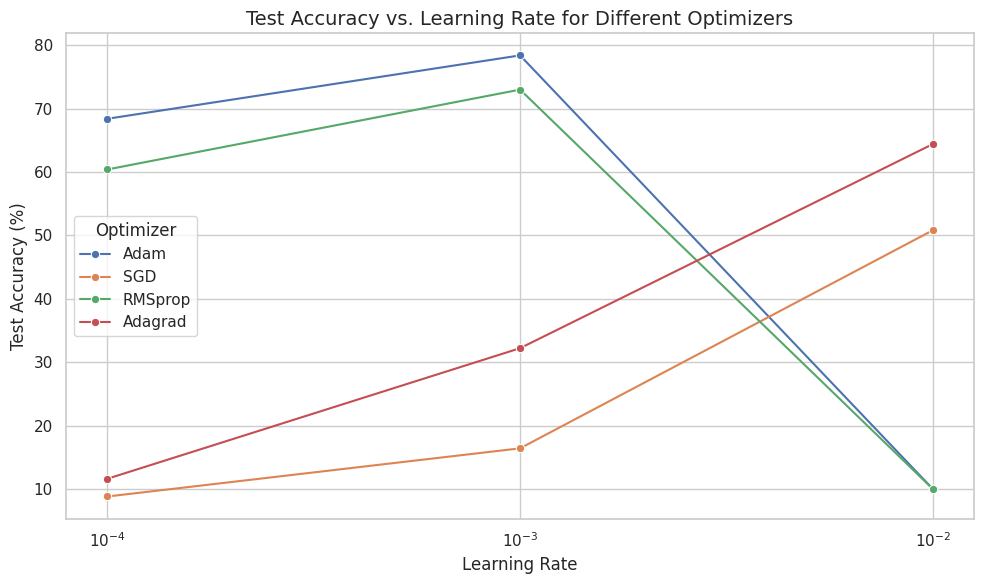

In [ ]:
df_3 = pd.DataFrame(results_3, columns=["Optimizer", "Learning Rate", "Accuracy"])
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_3, x="Learning Rate", y="Accuracy", hue="Optimizer", marker="o")
plt.title("Test Accuracy vs. Learning Rate for Different Optimizers", fontsize=14)
plt.xlabel("Learning Rate")
plt.ylabel("Test Accuracy (%)")
plt.legend(title="Optimizer")
plt.xscale("log")
plt.tight_layout()
plt.show()

## 5. Using various batch sizes and epochs for training

In [ ]:
output_3 = []

for batch_size in batch_sizes:
    for num_epochs in epochs_list:
        print(f"\nTraining with batch size {batch_size} and epochs {num_epochs}")
        model = build_model()
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(
            x_train_final_2, y_train_final_2,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_test_final_2, y_test_final_2)
        )

        test_loss, test_acc = model.evaluate(x_test_final_2, y_test_final_2, verbose=0)
        print(f"Accuracy: {test_acc * 100:.2f}%")
        output_3.append((batch_size, num_epochs, test_acc * 100))


Training with batch size 32 and epochs 10
Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.1769 - loss: 2.1936 - val_accuracy: 0.3580 - val_loss: 1.7760
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4047 - loss: 1.6828 - val_accuracy: 0.4560 - val_loss: 1.4822
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5382 - loss: 1.2977 - val_accuracy: 0.5600 - val_loss: 1.2349
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6213 - loss: 1.0806 - val_accuracy: 0.6280 - val_loss: 1.1089
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6579 - loss: 0.9637 - val_accuracy: 0.6580 - val_loss: 1.0089
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6877 - loss: 0.9133 - val_accuracy: 0.6660 - val_loss: 0.9489
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7409 - loss: 0.7606 - val_accuracy: 0.6940 - val_loss: 0.8921
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7775 - lo

In [ ]:
print("Summary of batch size and epoch experiments:")
for batch_size, num_epochs, acc in output_3:
    print(f"Batch Size: {batch_size}, Epochs: {num_epochs} → Accuracy: {acc:.2f}%")

Summary of batch size and epoch experiments:
Batch Size: 32, Epochs: 10 → Accuracy: 68.00%
Batch Size: 32, Epochs: 20 → Accuracy: 75.60%
Batch Size: 32, Epochs: 30 → Accuracy: 75.60%
Batch Size: 64, Epochs: 10 → Accuracy: 72.40%
Batch Size: 64, Epochs: 20 → Accuracy: 74.80%
Batch Size: 64, Epochs: 30 → Accuracy: 75.20%
Batch Size: 128, Epochs: 10 → Accuracy: 68.00%
Batch Size: 128, Epochs: 20 → Accuracy: 73.40%
Batch Size: 128, Epochs: 30 → Accuracy: 73.80%


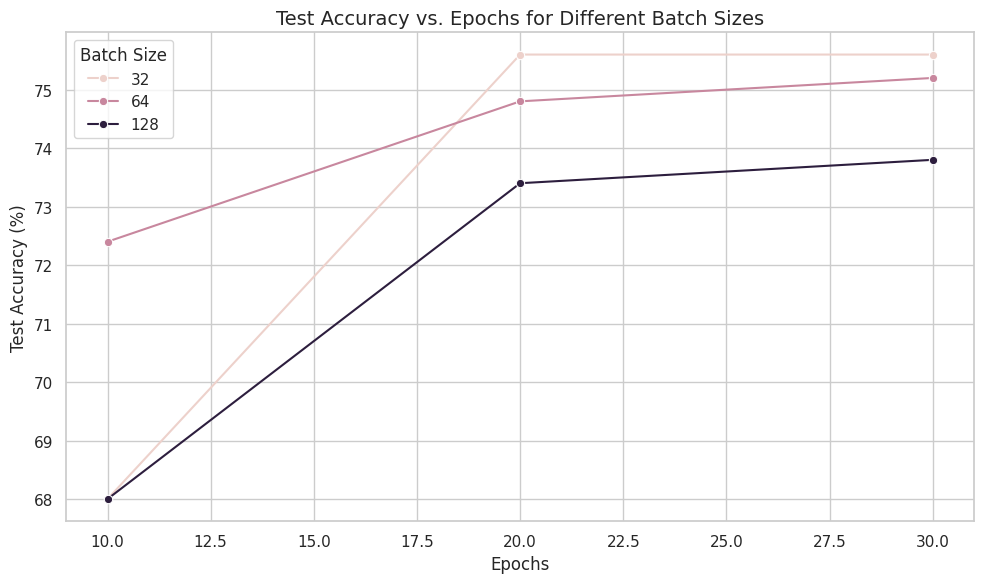

In [ ]:
df_batch_3 = pd.DataFrame(output_3, columns=["Batch Size", "Epochs", "Accuracy"])
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_batch_3, x="Epochs", y="Accuracy", hue="Batch Size", marker="o")
plt.title("Test Accuracy vs. Epochs for Different Batch Sizes", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy (%)")
plt.legend(title="Batch Size")
plt.tight_layout()
plt.show()